# CROP-seq KO150 - Mixscape analysis of all cells simultaneously
- input: filtered seurat object
- output: real perturbed cells, LDA UMAP plot,...

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(dplyr)
library(reshape2)
library(stringr)
library(ggrepel)


# Setup custom theme for plotting.
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# configs
data_path <- file.path('results','KO150')

fine_mode <- FALSE
# fine_mode <- TRUE

if (fine_mode){
    mixscape_dir = "mixscape_finemode"
} else{
    mixscape_dir = "mixscape"
}

results_path <- file.path(data_path, mixscape_dir, 'all')

In [4]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE, recursive = TRUE)

# load filtered Seurat object

In [5]:
# loading Seurat object
KO150 <-readRDS(file = file.path(data_path,paste0("KO150_filtered_Seurat.rds")))
KO150

An object of class Seurat 
31673 features across 28303 samples within 4 assays 
Active assay: gRNA (600 features, 0 variable features)
 3 other assays present: RNA, AB, HTO

## prepare metadata

In [6]:
KO150[['condition']] <- str_split_fixed(KO150$hto_demux, "_", 2)[,2]

In [7]:
KO150$KO_call[KO150$KO_call=='NonTargeting-'] <- 'NonTargeting'

# prepare seurat object for mixscape analysis
ie create new columns, named accoring to example data of vignette

In [8]:
# column gene
KO150[["gene"]] <- KO150$KO_call
KO150$gene[KO150$gene=="NonTargeting"] <- 'NT'

In [9]:
# column NT
KO150[["NT"]] <- str_replace(KO150$guide_call, '-', 'g')
KO150$NT[grep("^NonTargeting",KO150$NT)] <- 'NT'

In [10]:
# column crispr for distinguishing perturbed & non-perturbed cells
KO150[["crispr"]] <- KO150$gene
KO150$crispr[KO150$crispr!="NT"] <- "Perturbed"

In [11]:
KO150[[c("gene","NT","crispr")]][1:40,]

,gene,NT,crispr
,<chr>,<chr>,<chr>
A1_AAACCTGAGAATCTCC-1,Chd7,Chd7g2,Perturbed
A1_AAACCTGAGCGATGAC-1,Babam1,Babam1g1,Perturbed
A1_AAACCTGAGTGCCAGA-1,Mov10,Mov10g4,Perturbed
A1_AAACCTGAGTGGAGAA-1,Spi1,Spi1g1,Perturbed
A1_AAACCTGAGTTTAGGA-1,Jmjd1c,Jmjd1cg3,Perturbed
A1_AAACCTGCACATTCGA-1,Ezh2,Ezh2g1,Perturbed
A1_AAACCTGCATGCTGGC-1,Smc1a,Smc1ag4,Perturbed
A1_AAACCTGGTAATTGGA-1,Ifi203,Ifi203g4,Perturbed
A1_AAACCTGGTAGGCATG-1,Elp2,Elp2g2,Perturbed


# Mixscape

In [12]:
# Normalize protein.
KO150 <- NormalizeData(
  object = KO150, 
  assay = "AB", 
  normalization.method = "CLR", 
  margin = 2)

Normalizing across cells



In [13]:
# Prepare RNA assay for dimensionality reduction: 
# Normalize data, find variable features and scale data.
DefaultAssay(object = KO150) <- 'RNA'
KO150 <- NormalizeData(object = KO150) %>% FindVariableFeatures() %>% ScaleData()

# Run Principle Component Analysis (PCA) to reduce the dimensionality of the data.
KO150 <- RunPCA(object = KO150)

# Run Uniform Manifold Approximation and Projection (UMAP) to visualize clustering in 2-D.
KO150 <- RunUMAP(object = KO150, dims = 1:40)

Centering and scaling data matrix

PC_ 1 
Positive:  Rsad2, Acod1, Ifit1, Isg15, Ifit2, Oasl1, Cmpk2, Ifit3, Marcksl1, Slfn2 
	   Ifih1, Ccl3, Cd40, Ccrl2, Cxcl2, Ccl4, Ccl5, AC133103.1, A530040E14Rik, Ifi202b 
	   Isg20, Traf1, Tnf, Usp18, Gbp2, Rap1b, Tor3a, Sqstm1, Aftph, Ccl2 
Negative:  Tubb5, Tk1, Pclaf, Stmn1, Gmnn, H2afx, Birc5, Dut, Scd2, Cks1b 
	   Aurkb, Hist1h1b, Hmgb2, Mki67, Hist1h1e, Rrm2, Asf1b, Cdca3, Ccna2, Tipin 
	   Lmnb1, Top2a, Cdca8, Kif23, Txnip, Cenpa, Ube2t, Anln, Rrm1, Ccnb2 
PC_ 2 
Positive:  Sfpq, Srsf6, Ube2c, Hmgb2, Ccna2, Pclaf, Ube2s, Smc2, Cks1b, Ccnb1 
	   Slfn9, Ckap2l, Pttg1, Top2a, Mki67, Cdk1, Icam1, Parp14, Birc5, Stmn1 
	   Parp12, Ifi47, Tacc3, Cenpe, Tubb4b, Mb21d1, Irgm1, Knl1, Ccnb2, Tpx2 
Negative:  Hmox1, Ftl1, Fth1, Procr, Hilpda, Lcn2, Fosl2, Csf3, Urah, Vegfa 
	   Plin2, Glipr2, Neat1, Ctsl, Esd, Cd36, Upp1, Mxi1, Ftl1-ps1, Pid1 
	   Msr1, Prr13, Ctsd, Prdx5, 1110008P14Rik, Plekho1, Cd14, Saa3, Nr4a1, Rras 
PC_ 3 
Positive:  Ubald2, Ura

In [14]:
mouseHumanGenes <- read.table(file = file.path("resources","HOM_MouseHumanSequence.rpt"), sep = '\t', header = TRUE)

In [15]:
# convert human cell cycle genes to murine genes
m.g2m.genes <- vector()

for (human_gene in cc.genes$g2m.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.g2m.genes <- append(m.g2m.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.g2m.genes

In [16]:
# convert human cell cycle genes to murine genes
m.s.genes <- vector()

for (human_gene in cc.genes$s.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.s.genes <- append(m.s.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.s.genes

In [17]:
# determine cell cycle scores
s.genes <- m.s.genes
g2m.genes <- m.g2m.genes
KO150 <- CellCycleScoring(KO150, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

In [18]:
DefaultAssay(object = KO150) <- 'RNA'

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 1378 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 1378 rows containing missing values (geom_point).”


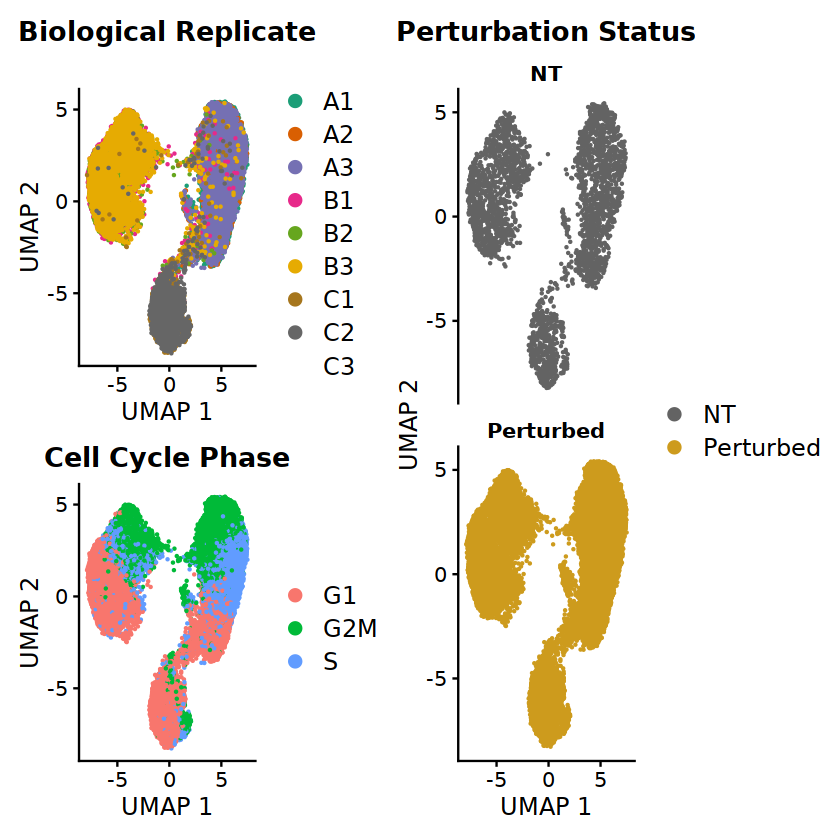

In [19]:
# Generate plots to check if clustering is driven by biological replicate ID, 
# cell cycle phase or target gene class.
p1 <- DimPlot(
  object = KO150, 
  group.by = 'batch', 
  label = F, 
  pt.size = 0.2, 
  reduction = "umap", cols = "Dark2", repel = T) +
  scale_color_brewer(palette = "Dark2") +
  ggtitle("Biological Replicate") +
  xlab("UMAP 1") +
  ylab("UMAP 2") +
  custom_theme

p2 <- DimPlot(
  object = KO150, 
  group.by = 'Phase', 
  label = F, pt.size = 0.2, 
  reduction = "umap", repel = T) + 
  ggtitle("Cell Cycle Phase") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

p3 <- DimPlot(
  object = KO150, 
  group.by = 'crispr', 
  pt.size = 0.2, 
  reduction = "umap", 
  split.by = "crispr", 
  ncol = 1, 
  cols = c("grey39","goldenrod3")) + 
  ggtitle("Perturbation Status") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

# Visualize plots.
((p1 / p2 + plot_layout(guides = 'auto')) | p3 )
# ((p1 / p1 + plot_layout(guides = 'auto')) | p3 )

ggsave(
  paste0("KO150_","_UMAP_prePerturbScore",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [20]:
# Calculate perturbation signature (PRTB).
KO150 <- CalcPerturbSig(
  object = KO150, 
  assay = "RNA", 
  slot = "data", 
  gd.class ="gene", 
  nt.cell.class = "NT", 
  reduction = "pca", 
  ndims = 40, 
  num.neighbors = 30, 
  split.by = "condition", # experiment
  new.assay.name = "PRTB")

Processing untreated

Processing LO28-6h

Processing LO28-24h



In [21]:
# Prepare PRTB assay for dimensionality reduction: 
# Normalize data, find variable features and center data.
DefaultAssay(object = KO150) <- 'PRTB'

# Use variable features from RNA assay.
VariableFeatures(object = KO150) <- VariableFeatures(object = KO150[["RNA"]])
KO150 <- ScaleData(object = KO150, do.scale = F, do.center = T)

# Run PCA to reduce the dimensionality of the data.
KO150 <- RunPCA(object = KO150, reduction.key = 'prtbpca', reduction.name = 'prtbpca')

# Run UMAP to visualize clustering in 2-D.
KO150 <- RunUMAP(
  object = KO150, 
  dims = 1:40, 
  reduction = 'prtbpca', 
  reduction.key = 'prtbumap', 
  reduction.name = 'prtbumap')

Centering data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prtbpca to prtbpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to prtbpca_”
prtbpca_ 1 
Positive:  Ahnak, Scd2, Rab7b, Tmem176a, Lars2, Adssl1, Hist1h1d, Bhlhe40, Gmnn, Tmem176b 
	   Mcm2, Gpr183, Mxi1, Tk1, Itga4, Selenbp2, Klf2, Hist1h1b, Cx3cr1, Rab3il1 
	   Alox5, Plec, Dtl, Gm42418, Snhg20, Cdkn1b, Map4k4, Ypel3, Crip1, Pltp 
Negative:  Ccl2, Cxcl2, Ccl5, Ccl7, Ccl4, Il1b, Tnf, Cxcl10, Acod1, Ccl3 
	   Rsad2, Csf3, Il1a, Plk2, Spp1, Oasl1, Ptgs2, Rgs1, Phlda1, Cmpk2 
	   Ccl9, Ier3, Ifit2, Marcksl1, Ifit1, Isg15, Atf3, Odc1, Plaur, Cd14 
prtbpca_ 2 
Positive:  Isg15, Rsad2, Ifit2, Irf7, Cmpk2, Usp18, Ifit1, Ifit3, Cxcl10, Oasl1 
	   Rtp4, Phf11d, Oasl2, Xaf1, Isg20, Ifi207, Ifi202b, Stat1, Irgm1, Ifih1 
	   Lgals9, Apol9a, Slfn4, Slfn2, Tor3a, Ifi203, Trim30a, Ccl5, Rnf213, 

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 1378 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 1378 rows containing missing values (geom_point).”


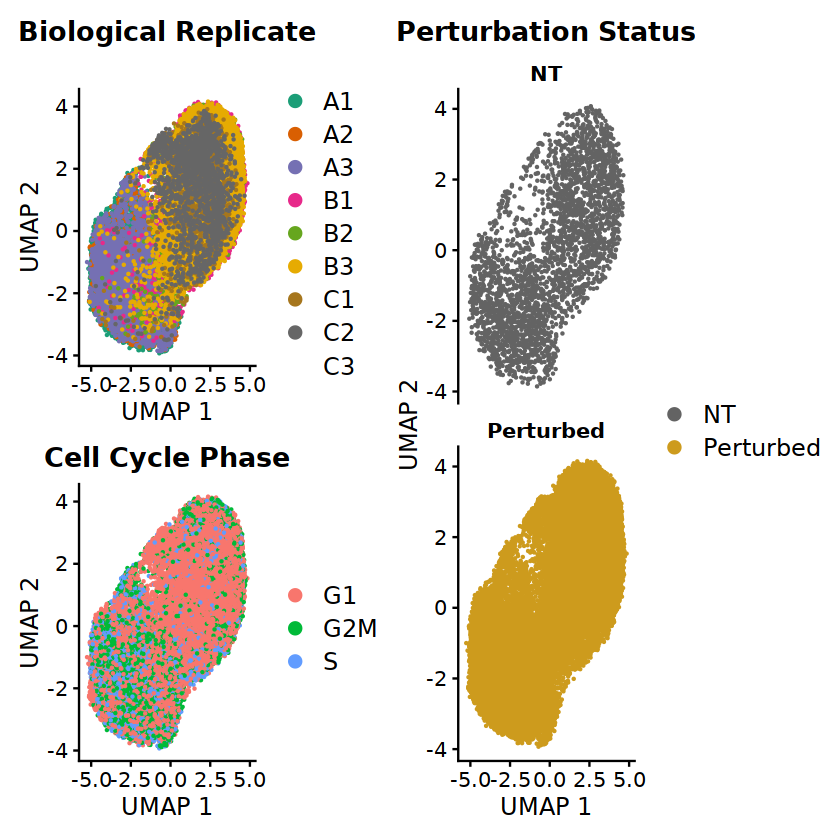

In [22]:
# Generate plots to check if clustering is driven by biological replicate ID, 
# cell cycle phase or target gene class.
q1 <- DimPlot(
  object = KO150, 
  group.by = 'batch', 
  reduction = 'prtbumap', 
  pt.size = 0.2, cols = "Dark2", label = F, repel = T) +
  scale_color_brewer(palette = "Dark2") +
  ggtitle("Biological Replicate") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

q2 <- DimPlot(
  object = KO150, 
  group.by = 'Phase', 
  reduction = 'prtbumap', 
  pt.size = 0.2, label = F, repel = T) +
  ggtitle("Cell Cycle Phase") +
  ylab("UMAP 2") +
  xlab("UMAP 1") + 
  custom_theme

q3 <- DimPlot(
  object = KO150,
  group.by = 'crispr',
  reduction = 'prtbumap', 
  split.by = "crispr", 
  ncol = 1, 
  pt.size = 0.2, 
  cols = c("grey39","goldenrod3")) +
  ggtitle("Perturbation Status") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

# Visualize plots.
(q1 / q2 + plot_layout(guides = 'auto') | q3)
# (q1 / q1 + plot_layout(guides = 'auto') | q3)

ggsave(
  paste0("KO150_","_UMAP_postPerturbScore",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [23]:
# Run mixscape.
KO150 <- RunMixscape(
  object = KO150, 
  assay = "PRTB", 
  slot = "scale.data", 
  labels = "gene", 
  nt.class.name = "NT", 
  min.de.genes = 5,
  iter.num = 10, 
  de.assay = "RNA", 
  verbose = F,
    fine.mode = fine_mode,
  fine.mode.labels = "NT",
  prtb.type = "KO",
    split.by="condition",
    logfc.threshold = 0.1 # default 0.25
)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

number of iterations= 34 
number of iterations= 16 
number of iterations= 77 
number of iterations= 42 
number of iterations= 38 
number of iterations= 28 
number of iterations= 18 
number of iterations= 90 
number of iterations= 59 
number of iterations= 58 
number of iterations= 32 
number of iterations= 30 
number of iterations= 538 
number of iterations= 504 
number of iterations= 591 
number of iterations= 25 
number of iterations= 22 
number of iterations= 183 
number of iterations= 140 
number of iterations= 116 
number of iterations= 100 
number of iterations= 78 
number of iterations= 249 
number of iterations= 61 
number of iterations= 39 
number of iterations= 25 
number of iterations= 76 
number of iterations= 52 
number of iterations= 51 
number of iterations= 50 
number of iterations= 48 
number of iterations= 25 
number of iterations= 25 
number of iterations= 15 
number of iterations= 12 
number of iterations= 11 
number of iterations= 10 
number of iterations= 26 
numb

In [24]:
# save Seurat object
saveRDS(KO150, file = file.path(results_path,paste0("KO150_mixscape_Seurat.rds")))

In [5]:
# loading Seurat object
KO150 <-readRDS(file = file.path(results_path,paste0("KO150_mixscape_Seurat.rds")))
KO150

An object of class Seurat 
34344 features across 28303 samples within 5 assays 
Active assay: PRTB (2671 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 4 dimensional reductions calculated: pca, umap, prtbpca, prtbumap

In [25]:
# save matrix of PRTB counts
PRTB <- GetAssayData(object = KO150, slot = "data")
dim(PRTB)
head(PRTB)
write.csv(PRTB, file=file.path(results_path,paste0('KO150_mixscape_PRTB','.csv')), row.names=TRUE)

[1]  2735 28303

,A1_AAACCTGAGAATCTCC-1,A1_AAACCTGAGCGATGAC-1,A1_AAACCTGAGTGCCAGA-1,A1_AAACCTGAGTGGAGAA-1,A1_AAACCTGAGTTTAGGA-1,A1_AAACCTGCACATTCGA-1,A1_AAACCTGCATGCTGGC-1,A1_AAACCTGGTAATTGGA-1,A1_AAACCTGGTAGGCATG-1,A1_AAACCTGGTATATCCG-1,⋯,C3_TTTGCGCTCAAACCGT-1,C3_TTTGCGCTCACCAGGC-1,C3_TTTGCGCTCCAGAAGG-1,C3_TTTGGTTAGCCGATTT-1,C3_TTTGGTTAGTGAAGAG-1,C3_TTTGGTTCACCGATAT-1,C3_TTTGGTTGTCAGATAA-1,C3_TTTGGTTGTCGCTTTC-1,C3_TTTGGTTGTTCCATGA-1,C3_TTTGTCATCGCCCTTA-1
Saa3,0.05549714,0.06663288,0.04415404,0.01871277,0.06909651,0.06235979,0.09951521,0.07531642,0.1369073,0.07042151,⋯,-0.39829381,1.486583581,1.18852459,1.1948671,2.8117321,1.76078486,2.11748555,0.5905219,1.84869047,1.47873632
Cxcl3,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,⋯,0.04645595,0.067339129,0.12263907,-0.4518315,-0.7489249,0.01508279,0.03506969,1.9802036,0.62050115,0.23257552
S100a8,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,⋯,0.08112809,0.139241400,0.17340100,1.6847888,0.2585859,0.14861172,-3.01356655,0.1528655,0.74289915,1.67033611
Csf2,0.00000000,0.02103702,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,⋯,-0.80452259,0.007499154,0.03704026,0.2079396,0.3967799,0.16930521,0.29560641,0.0000000,0.00000000,0.09055046
Gm5483,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000,⋯,0.49959374,-0.022192577,0.31880728,0.6985553,0.1078331,0.43587663,1.17620663,0.2944704,0.07527243,0.49696379
Timp1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03328427,0.00000000,0.00000000,0.0000000,0.00000000,⋯,-0.13569727,0.029086112,0.05963120,-1.5743230,-0.8413633,0.21492305,-1.48281249,1.1934666,-0.35644197,-0.01014255


In [26]:
# save mixscape annotation data
write.csv(
    KO150[[c('mixscape_class', 'mixscape_class_p_ko', 'mixscape_class.global')]],
    file = file.path(results_path,paste0("KO150_mixscape_annotations.csv")),
    row.names=TRUE
    )

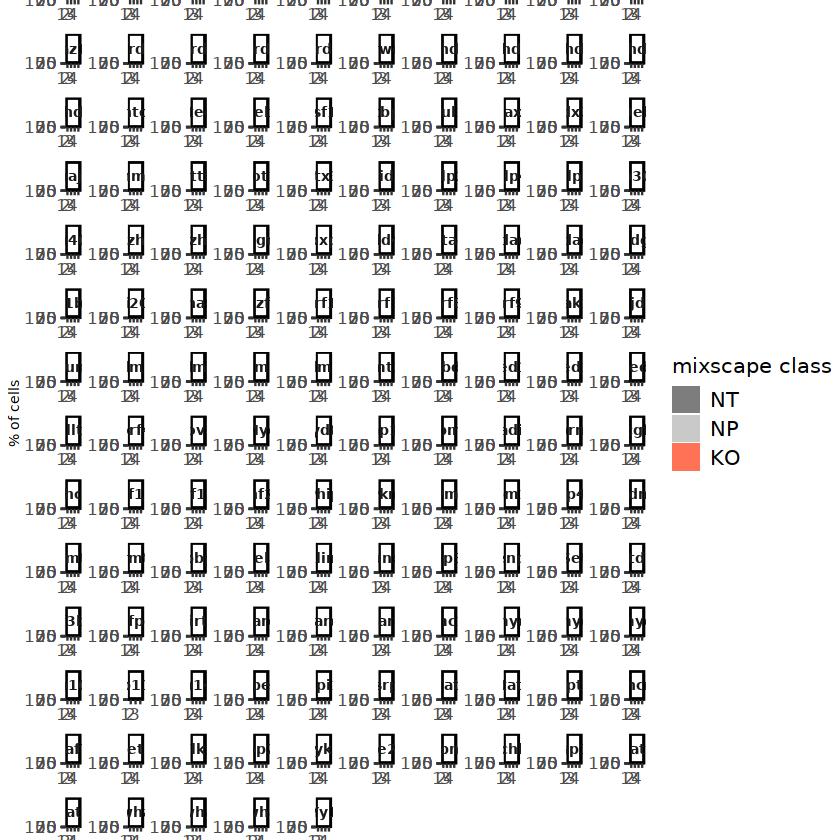

In [27]:
# Calculate percentage of KO cells for all target gene classes.
df <- prop.table(table(KO150$mixscape_class.global, KO150$NT),2)

df2 <- reshape2::melt(df)
df2$Var2 <- as.character(df2$Var2)
test <- df2[which(df2$Var1 == "KO"),]
test <- test[order(test$value, decreasing = T),]
new.levels <- test$Var2
df2$Var2 <- factor(df2$Var2, levels = new.levels )
df2$Var1 <- factor(df2$Var1, levels = c("NT", "NP", "KO"))
df2$gene <- sapply(as.character(df2$Var2), function(x) gsub("g.$", "", x))
df2$guide_number <- sapply(as.character(df2$Var2), 
                           function(x) tail(strsplit(x, split = "g")[[1]],1))
df3 <- df2[-c(which(df2$gene == "NT")),]

p1 <- ggplot(df3, aes(x = guide_number, y = value*100, fill= Var1)) +
  geom_bar(stat= "identity") +
  theme_classic()+
  scale_fill_manual(values = c("grey49", "grey79","coral1")) + 
  ylab("% of cells") +
  xlab("sgRNA")

p1 + theme(axis.text.x = element_text(size = 10, hjust = 1), 
           axis.text.y = element_text(size = 10), 
           axis.title = element_text(size = 8), 
           strip.text = element_text(size=8, face = "bold")) + 
  facet_wrap(vars(gene),ncol = 10, scales = "free") +
  labs(fill = "mixscape class") +theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12))

ggsave(
  paste0("KO150_","_PercentageKO_all",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
    height=20,
    width=20
)

### Unsupervised analysis of PRTB perturbed cells

In [28]:
# Remove non-perturbed cells and run LDA to reduce the dimensionality of the data.
Idents(KO150) <- "mixscape_class.global"
sub_test <- subset(KO150, idents = c("KO", "NT"))
sub_test

An object of class Seurat 
34408 features across 6198 samples within 5 assays 
Active assay: PRTB (2735 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 4 dimensional reductions calculated: pca, umap, prtbpca, prtbumap

In [29]:
# make new labels: condition+KO
sub_test[["gene_new"]] <- paste(sub_test$condition,sub_test$gene,sep="+")
# sub_all$gene_new[grep("+NT$",sub_all$gene_new)] <- 'NT'
unique(sub_test$gene_new)

[1] "untreated+Smc1a"   "untreated+Ifnar1"  "untreated+Sfpq"   
 [4] "untreated+Tyk2"    "untreated+NT"      "untreated+Irf9"   
 [7] "untreated+Ep300"   "untreated+Spi1"    "untreated+Ep400"  
[10] "untreated+Arid1a"  "untreated+Ikzf1"   "untreated+Dnttip2"
[13] "untreated+Brd2"    "untreated+Stat2"   "untreated+Chd4"   
[16] "untreated+Yeats2"  "untreated+Jak1"    "untreated+Dnmt1"  
[19] "untreated+Med14"   "untreated+Sf3b1"   "untreated+Chd8"   
[22] "untreated+Runx1"   "LO28-6h+Irf9"      "LO28-6h+Smarca4"  
[25] "LO28-6h+NT"        "LO28-6h+Ep300"     "LO28-6h+Spi1"     
[28] "LO28-6h+Arid1a"    "LO28-6h+Dnmt1"     "LO28-6h+Ep400"    
[31] "LO28-6h+Ikzf1"     "LO28-6h+Myd88"     "LO28-6h+Brd2"     
[34] "LO28-6h+Runx1"     "LO28-6h+Smc1a"     "LO28-6h+Stat1"    
[37] "LO28-6h+Yeats4"    "LO28-6h+Med14"     "LO28-6h+Jak1"     
[40] "LO28-6h+Med8"      "LO28-6h+Dnttip2"   "LO28-6h+Ifnar1"   
[43] "LO28-6h+Yeats2"    "LO28-6h+Stat2"     "LO28-6h+Chd4"     
[46] "LO28-6h+Irf3"      "LO28-6h+Sfpq"      "LO28-6h+Ddx21"    
[49] "LO28-24h+Stat2"    "LO28-24h+Smc1a"    "LO28-24h+NT"      
[52] "LO28-24h+Spi1"     "LO28-24h+Tyk2"     "LO28-24h+Jak1"    
[55] "LO28-24h+Ifnar1"   "LO28-24h+Chd4"     "LO28-24h+Irf9"    
[58] "LO28-24h+Ikzf1"    "LO28-24h+Myd88"    "LO28-24h+Sfpq"    
[61] "LO28-24h+Ep400"

In [30]:
DefaultAssay(object = sub_test)

[1] "PRTB"

In [31]:
DefaultAssay(object = sub_test) <- 'RNA'
sub_test <- NormalizeData(object = sub_test) %>% FindVariableFeatures() %>% ScaleData()
# Prepare PRTB assay for dimensionality reduction: 
# Normalize data, find variable features and center data.
DefaultAssay(object = sub_test) <- 'PRTB'

# Use variable features from RNA assay.
VariableFeatures(object = sub_test) <- VariableFeatures(object = sub_test[["RNA"]])
sub_test <- ScaleData(object = sub_test, do.scale = F, do.center = T)

Centering and scaling data matrix

Warning message:
“Not all features provided are in this Assay object, removing the following feature(s): Bmp1, Celf6, Gm34425, Epm2aip1, Gm16194, Efcc1, Gm36445, Fam71a, Megf11, Gm36266, Btnl2, Dusp15, Siglec15, Gm10851, B630019K06Rik, Gm12648, Hecw2, Lbp, Reps2, Gm16587, Plekha6, St8sia4, Cat, Sycp3, Sdr39u1, Rapgef3, Myo5b, Serpind1, Cul9, Tulp2, Actn3, Dyrk4, Klhdc7a, Hgsnat, Neo1, Colgalt2, Wfdc1, Prrxl1, Terb2, 1700013H16Rik, Gdpd2, Slc30a3, Dmrtc2, Ap3b2, Il22ra2, Gm28651, Klf12, Arhgap32, Slc26a3, Card10, Sh3bgr, Plekhh2, Gm49392, Adamts7, Pls3, Pla2g2e, Glcci1, 4930461G14Rik, Lyzl4, Slc26a4, Klhl6, Timeless, Gm128, Chn2, Bora, Arnt2, Necab2, Siglecg, Lrrc23, Traf4, Gm28901, Selenop, Gm48727, Patj, 1700003M07Rik, Adrb2, 9130230L23Rik, Aif1l, Gcg, 1700095J07Rik, Gimap8, Gm48065, Gm10660, Loxl2, Olfm4, 4933405E24Rik, Fam50b, Spata31d1b, Kcnk10, G930009F23Rik, Ms4a1, Tdrd12, E430024P14Rik, Gpat2, Dmwd, Gpr62, Apol7a, Shisa3, N4bp2l1, Rnf183, Gpr85

In [32]:
# Run PCA to reduce the dimensionality of the data.
sub_test <- RunPCA(object = sub_test, reduction.key = 'prtbpca', reduction.name = 'prtbpca')

# Run UMAP to visualize clustering in 2-D.
sub_test <- RunUMAP(
  object = sub_test, 
  dims = 1:40, 
  reduction = 'prtbpca', 
  reduction.key = 'prtbumap', 
  reduction.name = 'prtbumap')

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prtbpca to prtbpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to prtbpca_”
prtbpca_ 1 
Positive:  Ahnak, Scd2, Lyz2, Cst7, Klf2, Cx3cr1, Bhlhe40, Tmem176a, Rab3il1, Rab7b 
	   Gmnn, Plec, Zfp36l2, Adssl1, Hist1h1d, Cxcl14, Slc11a1, Alox5, Selenbp2, Fnip2 
	   P4hb, Flna, Ero1l, Tk1, Rhox5, Mcm2, Csf2rb, Anpep, Rnf149, Gpr137b 
Negative:  Cxcl2, Rsad2, Ccl2, Cxcl10, Isg15, Irf7, Usp18, Oasl1, Ccl5, Cmpk2 
	   Ifit2, Bst2, Ifit1, Ifi27l2a, Ccl4, Il1b, Acod1, Ifit3, Tnf, Slfn4 
	   Phf11d, Xaf1, Rtp4, Ifi202b, Plk2, Ccl3, Csf3, Isg20, Lgals9, Il1a 
prtbpca_ 2 
Positive:  Irf7, Bst2, Isg15, Usp18, Ifi27l2a, Ifi44, Xaf1, Lgals9, Rtp4, Phf11d 
	   Ifi202b, Isg20, Ifit2, Oasl2, Stat1, Ifi207, Irgm1, Ifit3, Oas1a, Ifi35 
	   H2-T22, Apol9a, Ifit1, Trim30a, Ddx58, Rsad2, Rnf213, Sp100, Ifi203, Tap1 
Negative: 

Saving 6.67 x 6.67 in image



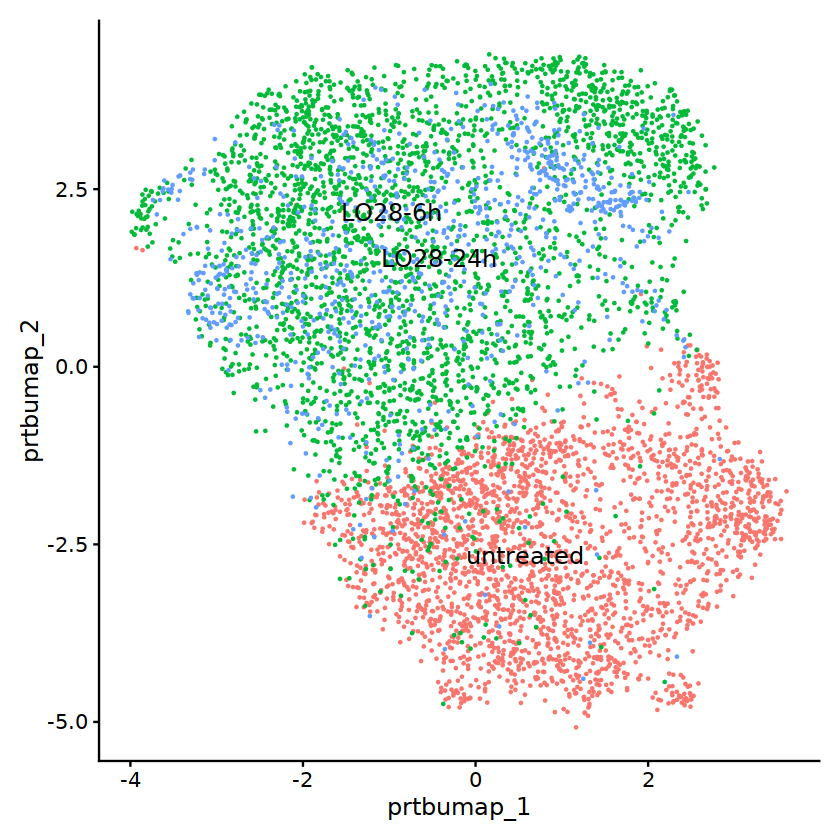

In [33]:
Idents(sub_test) <- "condition"

DimPlot(object = sub_test,
             reduction = "prtbumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
#              cols = col
            ) + NoLegend()

ggsave(
  paste0("KO150_",'UMAP_PRTB_condition', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


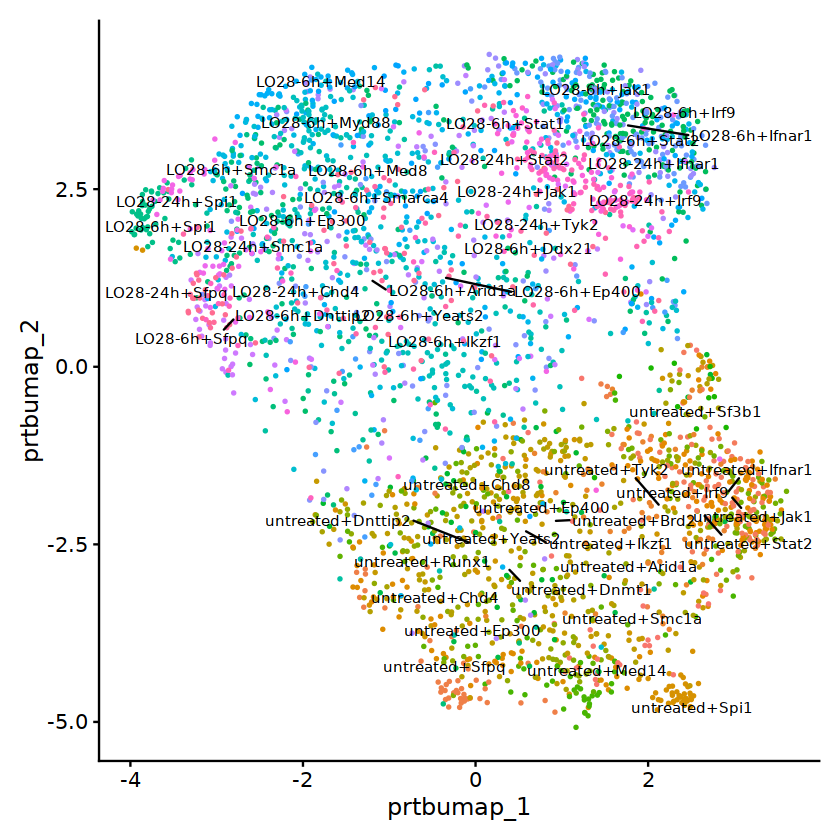

In [34]:
Idents(sub_test) <- "gene_new"

DimPlot(object = sub_test,
        cells=colnames(sub_test)[sub_test$mixscape_class!='NT'],
             reduction = "prtbumap", 
             repel = T, 
             label.size = 3, 
             label = T, 
#              cols = col
            ) + NoLegend()

ggsave(
  paste0("KO150_",'UMAP_PRTB_condition_KO', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

### LDA of PRTB perturbed cells

In [35]:
# Remove non-perturbed cells and run LDA to reduce the dimensionality of the data.
Idents(KO150) <- "mixscape_class.global"
sub <- subset(KO150, idents = c("KO", "NT"))

In [36]:
# Run LDA.
sub <- MixscapeLDA(
  object = sub, 
  assay = "RNA", 
  pc.assay = "PRTB", 
  labels = "gene", 
  nt.label = "NT", 
  npcs = 10, 
  logfc.threshold = 0.25, 
  verbose = F)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [37]:
# Use LDA results to run UMAP and visualize cells on 2-D. 
# Here, we note that the number of the dimensions to be used is equal to the number of 
# labels minus one (to account for NT cells).
sub <- RunUMAP(
  object = sub,
  dims = 1:(length(unique(sub$mixscape_class))-1),
  reduction = 'lda',
  reduction.key = 'ldaumap',
  reduction.name = 'ldaumap')

16:30:50 UMAP embedding parameters a = 0.9922 b = 1.112

16:30:50 Read 6198 rows and found 28 numeric columns

16:30:50 Using Annoy for neighbor search, n_neighbors = 30

16:30:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:30:52 Writing NN index file to temp file /home/sreichl/tmp//Rtmpb3OJUf/file44318d68d17

16:30:52 Searching Annoy index using 1 thread, search_k = 3000

16:30:55 Annoy recall = 100%

16:30:56 Commencing smooth kNN distance calibration using 1 thread

16:30:57 Initializing from normalized Laplacian + noise

16:30:57 Commencing optimization for 500 epochs, with 254916 positive edges

16:31:31 Optimization finished

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ldaumap to ldaumap_

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



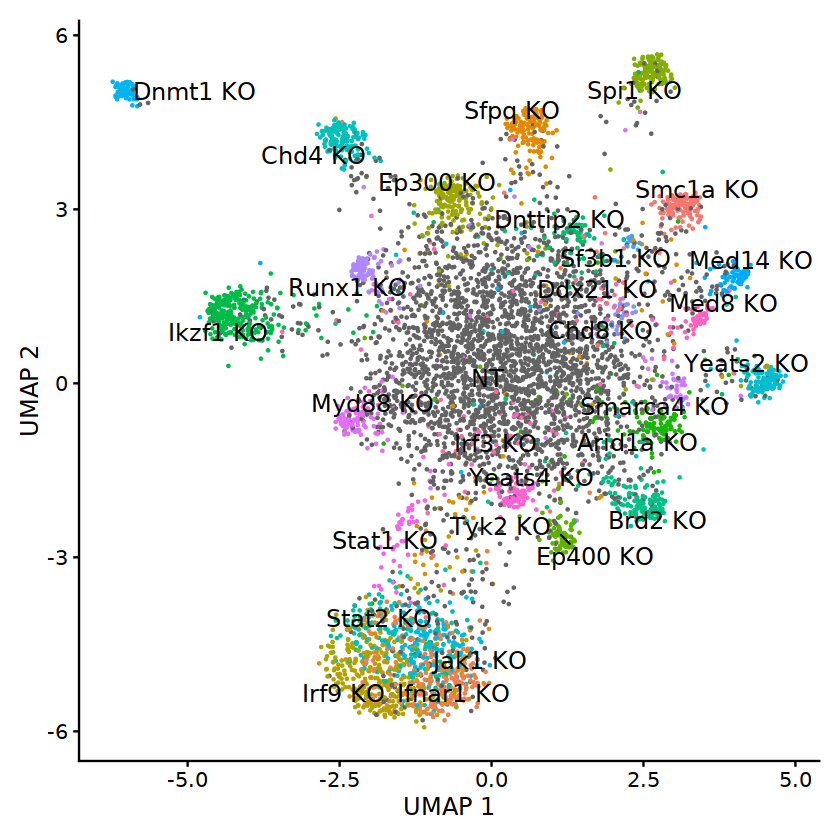

In [38]:
# Visualize UMAP clustering results.
Idents(sub) <- "mixscape_class"
sub$mixscape_class <- as.factor(sub$mixscape_class)

# Set colors for each perturbation.
col = setNames(object = hue_pal()(length(unique(sub$mixscape_class))),nm = unique(sub$mixscape_class))
# names(col) <- c(names(col)[1:7], "NT", names(col)[9:12])
col["NT"] <- "grey39"

p <- DimPlot(object = sub, 
             reduction = "ldaumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
             cols = col) + NoLegend()

p2 <- p+ 
  scale_color_manual(values=col, drop=FALSE) + 
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme
p2

ggsave(
  paste0("KO150_",'UMAP_LDA_KO_', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



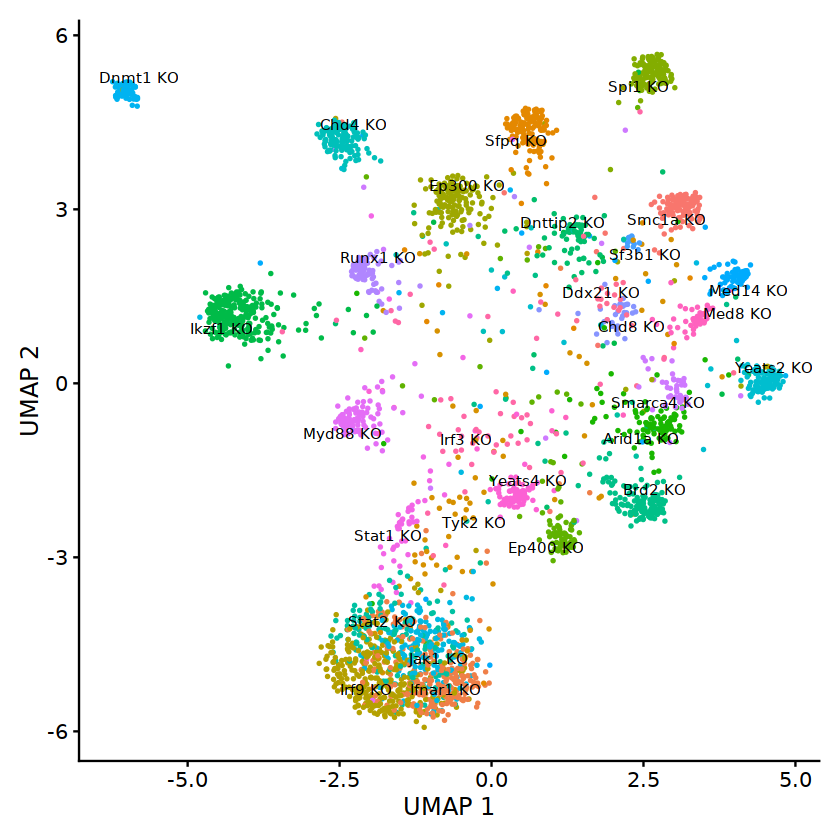

In [39]:
# Visualize UMAP clustering results without NT cells
Idents(sub) <- "mixscape_class"
sub$mixscape_class <- as.factor(sub$mixscape_class)

# Set colors for each perturbation.
col = setNames(object = hue_pal()(length(unique(sub$mixscape_class))),nm = unique(sub$mixscape_class))
# names(col) <- c(names(col)[1:7], "NT", names(col)[9:12])
col["NT"] <- "grey39"

p <- DimPlot(object = sub, 
             cells=colnames(sub)[sub$mixscape_class!='NT'],
             reduction = "ldaumap", 
             repel = T, 
             label.size = 3, 
             label = T, 
             cols = col) + NoLegend()

p2 <- p+ 
  scale_color_manual(values=col, drop=FALSE) + 
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme
p2

ggsave(
  paste0("KO150_",'UMAP_LDA_KO_','pure', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Saving 6.67 x 6.67 in image



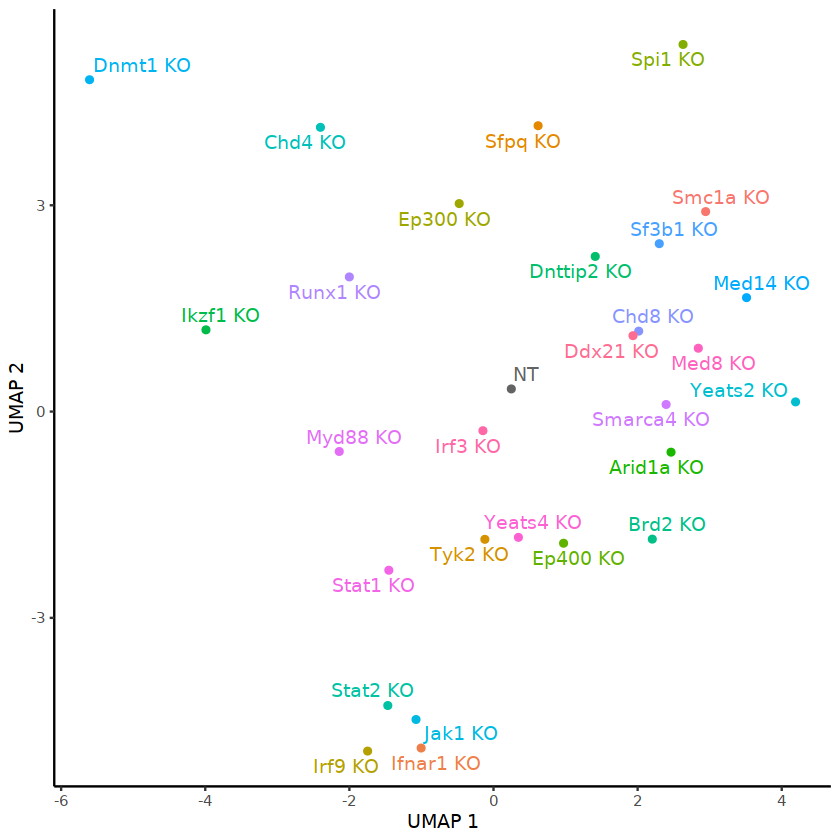

In [40]:
# plot only the centroids
ldaumap_data <- Embeddings(object = sub, reduction = "ldaumap")
ldaumap_data <- data.frame(ldaumap_data)
ldaumap_data$mixscape_class <- sub$mixscape_class[rownames(ldaumap_data)]

ldaumap_means <- aggregate(ldaumap_data[, c('ldaumap_1','ldaumap_2')], list(ldaumap_data$mixscape_class), mean)

p <- ggplot(ldaumap_means, aes(ldaumap_1, ldaumap_2, colour = Group.1)) + 
    geom_point()  + 
    geom_text_repel(aes(label=Group.1))

p1 <-  p+ 
    scale_color_manual(values=col, drop=FALSE) +
    ylab("UMAP 2") +
    xlab("UMAP 1") +
    theme_classic()+ 
    NoLegend()

p1

ggsave(
  paste0("KO150_",'UMAP_LDA_KO_','centroids', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [41]:
# save Seurat object
saveRDS(sub, file = file.path(results_path,paste0("KO150_mixscape_subset_Seurat.rds")))

In [4]:
# loading Seurat object
sub <-readRDS(file = file.path(results_path,paste0("KO150_mixscape_subset_Seurat.rds")))
sub

An object of class Seurat 
34364 features across 6906 samples within 5 assays 
Active assay: PRTB (2691 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 6 dimensional reductions calculated: pca, umap, prtbpca, prtbumap, lda, ldaumap